In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator, Aer
from qiskit.providers.fake_provider import FakeProvider, FakeManila, FakeToronto, FakeJakartaV2
from qiskit_aer.noise import NoiseModel
import qiskit.quantum_info as qi
import qiskit

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
module_path = os.path.abspath(os.path.join(module_path, '..')) # qrc_surrogate
sys.path.append(module_path)
plot_path = f'{module_path}/plots/plots_stm'

from src.feedforward import QExtremeLearningMachine
from src.rewinding import QRewindingRC, QRewindingStatevectorRC
from src.data import DataSource
from experiments.plotting.plotting import get_relevant_dataframe, show_average_lines, which_moi_does_this_column_have, \
    better_pointplot, select_values, select_values_range, sparse_ticks, average_df
from experiments.simulating.sweeps_paras import print_best_paras, get_paras, rseed_data_list, rseeds_circ

sns.set_style("whitegrid")
palette = 'muted' # muted deep colorblind dark
colors = sns.color_palette(palette).as_hex() 
sns.set_palette(sns.color_palette(palette))
# colors_sequential = sns.color_palette("viridis").as_hex()
colors_sequential = sns.color_palette("viridis")

module_path /Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate


# Plot results of logged experiments

Whenever we run a model, the parameters and results get logged in a dataframe.
In this notebook we access this dataframe and plot whatever we are interested in.

For each plot, we usually select some 'base settings' we are interested in (model_of_interest, data_of_interest), and then vary a single paramter that we plot.

In [2]:
# QExtremeLearningMachine QRewindingStatevectorRC
model_type = QRewindingStatevectorRC # <- select a model

# fullnames = glob.glob(f'{module_path}/experiments/results/' + r"*.parquet")
# print(f'Saved models:\n {fullnames}')

model = model_type()
print(f'Set model:\n {model.model_name}')
f = f'{module_path}/experiments/results/{model.model_name}.parquet'
df = pd.read_parquet(f)

# useful lists
passable_model_params = inspect.getfullargspec(model.__init__).args[1:]
passable_data_params = inspect.getfullargspec(DataSource().__init__).args[1:]
metrics = ['corr_train', 'corr_val', 'mse_train', 'mse_val', 'mape_train', 'mape_val', 'nrmse_train', 'nrmse_val', 'traintime']

print(f'Metrics in the dataframe\n: {passable_model_params}')

# metric we want to plot
ymetric = 'mape_val'


# Choose the parameters you want to plot
# Print the model parameters with the best validation score
# print_best_paras(experiment=experiment)

model_of_interest, data_of_interest = get_paras(model)

ytype = 'stm'
memory = 5
data_of_interest['xtype'] = 'random'
data_of_interest['ytype'] = ytype
data_of_interest['memory'] = memory
fname_data = ytype + str(memory)

print('Selected model parameters\n', model_of_interest)
print('Selected data parameters\n', data_of_interest)

df = pd.read_parquet(f)

Set model:
 rewinding_statevector_rc
Metrics in the dataframe
: ['sim_sampling', 'use_partial_meas', 'reset_instead_meas', 'lookback', 'lookback_max', 'add_y_to_input', 'restarting', 'mend', 'set_past_y_to_0', 'use_true_y_in_val', 'washout', 'preloading', 'mtype', 'minc', 'nmeas', 'reseti', 'resetm', 'rseed', 'log', 'add_x_as_feature', 'nyfuture', 'delete_future_y', 'fitter', 'regression_model', 'regression_alpha', 'regression_l1', 'poly_degree', 'nqubits', 'qctype', 'qinit', 'nlayers', 'ftype', 'enctype', 'encaxes', 'nenccopies', 'encangle', 'measaxes', 'shots', 'ising_t', 'ising_jmax', 'ising_h', 'ising_wmax', 'ising_random', 'ising_jpositive', 'ising_wpositive', 'sim', 't1', 'sim_method', 'sim_precision']
Selected model parameters
 {'qctype': 'ising', 'nyfuture': 1, 'lookback': 1, 'use_partial_meas': False, 'add_y_to_input': True, 'use_true_y_in_val': False, 'nmeas': 2, 'reset_instead_meas': False, 'measaxes': 'zyx', 'ising_t': 1.0, 'ising_h': 0.1, 'ising_jmax': 1, 'ising_wmax': 10,

# Ftype

<class 'numpy.ndarray'> [-0.05  0.95  1.95  2.95  3.95]
<class 'int'> 0
<class 'numpy.ndarray'> [0.05 1.05 2.05 3.05 4.05]
<class 'int'> 0


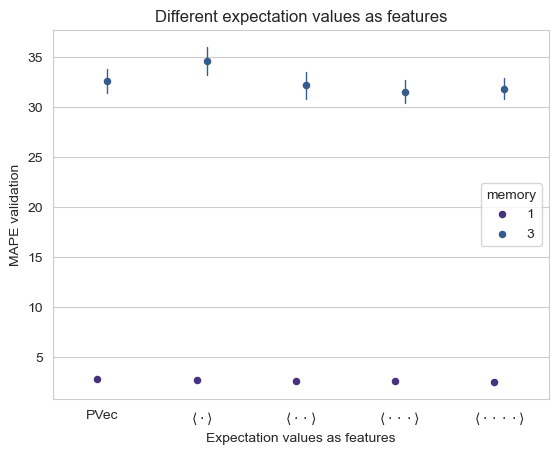

In [3]:
_xaxis_column = 'ftype'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['qctype']
hue_columns = ['nqubits']
hue_columns = ['measaxes']
hue_columns = []
hue_columns = ['memory']

df, hue = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column = _xaxis_column,
    _hue_columns = hue_columns,
    _keep_columns = ['rseed_data'],
    _cutoff = 30,
)
    

df = average_df(df, passable_model_params + passable_data_params)

ax = better_pointplot(
    x = _xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    palette=colors_sequential if hue is not None else None,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    linestyles='none',
    dodge = .1,
    errorbar = "sd", # ci # 95
    markers='.',
    errwidth=1,
)

# ax = show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Different expectation values as features')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_xticks(
    ax.get_xticks(),
    [
        # f'$\langle $' + f''.join([f' $\cdot $ ' for _ in range(int(ft))]) + f' $\rangle $' 
        r'$\langle ' + r''.join([r' \cdot ' for _ in range(int(ft))]) + r' \rangle $' 
        if int(ft) > 0
        else 'PVec'
        for ft in ax.get_xticks()
    ]
)
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Expectation values as features')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{_xaxis_column}.svg')
plt.show()

# Qubits

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


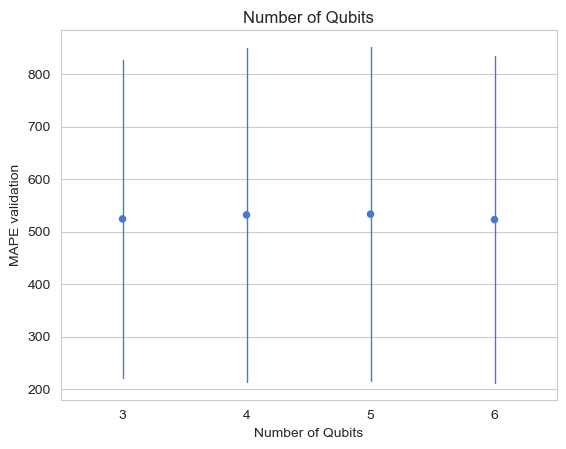

In [4]:
_xaxis_column = 'nqubits'

hue_columns = ['measaxes']
hue_columns = ['memory']
hue_columns = []

df, hue = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column = _xaxis_column,
    _change_moi = {'add_y_to_input': False},
    _hue_columns = hue_columns,
    _keep_columns = ['rseed_data'],
    # _cutoff = 30,
)

# average over different runs where paras are the same, e.g. same rseed_data
# df = average_df(df, passable_model_params + passable_data_params)

# df['memory'] = df['memory'].astype(int)
# df = df.sort_values('memory')
# hue = hue.sort_values()

ax = better_pointplot(
    x = _xaxis_column, y = ymetric, data = df, 
    hue=hue,
    palette=colors_sequential if hue is not None else None,
    dodge=.2,
    errwidth=1.,
    errorbar = "sd", # ci # 95
    linestyles='none',
    markers = '.',
)

# ax = show_average_lines(ax, df, hue_columns, ymetric)

if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
# ax.set_xticks([''])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Number of Qubits')
legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)
ax.set_title('Number of Qubits')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{_xaxis_column}.svg')
plt.show()

<class 'numpy.ndarray'> [0.9 1.9 2.9 3.9 4.9 5.9 6.9 7.9 8.9]
<class 'int'> 0
<class 'numpy.ndarray'> [0.96666667 1.96666667 2.96666667 3.96666667 4.96666667 5.96666667
 6.96666667 7.96666667 8.96666667]
<class 'int'> 0
<class 'numpy.ndarray'> [1.03333333 2.03333333 3.03333333 4.03333333 5.03333333 6.03333333
 7.03333333 8.03333333 9.03333333]
<class 'int'> 0
<class 'numpy.ndarray'> [1.1 2.1 3.1 4.1 5.1 6.1 7.1 8.1 9.1]
<class 'int'> 0


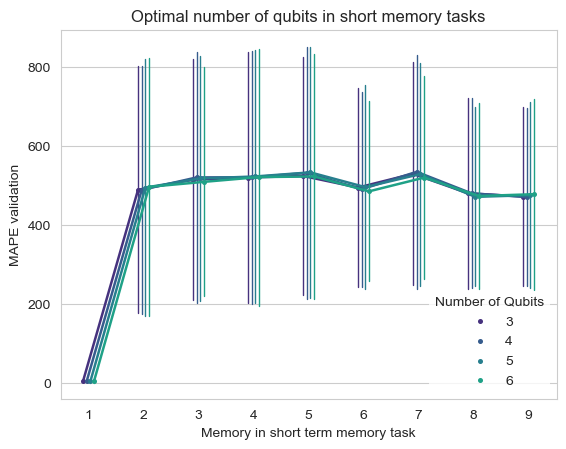

In [5]:
_xaxis_column = 'memory'

hue_columns = ['measaxes']
hue_columns = ['memory']
hue_columns = []
hue_columns = ['nqubits']

df, hue = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column = _xaxis_column,
    _change_moi = {'add_y_to_input': False},
    _hue_columns = hue_columns,
    _keep_columns = ['rseed_data'],
    # _cutoff = 30,
)

ax = better_pointplot(
    x = _xaxis_column, y = ymetric, data = df, 
    hue=hue,
    palette=colors_sequential if hue is not None else None,
    dodge=.2,
    errwidth=1.,
    errorbar = "sd", # ci # 95
    # linestyles='none',
    linestyles='-',
    linewidth=1,
    markers = '.',
    xpos=True,
)

# ax = show_average_lines(ax, df, hue_columns, ymetric)

if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_xticks(df[_xaxis_column].unique(), df[_xaxis_column].unique())
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Memory in short term memory task')
legend = ax.legend(frameon=True, title='Number of Qubits')
legend.get_frame().set_linewidth(0.0)
ax.set_title('Optimal number of qubits in short memory tasks')

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.autoscale()

# plt.savefig(f'{plot_path}/{experiment.model_name}_{fname_data}_{_xaxis_column}.svg')
plt.show()

<class 'numpy.ndarray'> [1.9 2.9 3.9 4.9 5.9 6.9 7.9 8.9]
<class 'int'> 0
<class 'numpy.ndarray'> [1.96666667 2.96666667 3.96666667 4.96666667 5.96666667 6.96666667
 7.96666667 8.96666667]
<class 'int'> 0
<class 'numpy.ndarray'> [2.03333333 3.03333333 4.03333333 5.03333333 6.03333333 7.03333333
 8.03333333 9.03333333]
<class 'int'> 0
<class 'numpy.ndarray'> [2.1 3.1 4.1 5.1 6.1 7.1 8.1 9.1]
<class 'int'> 0


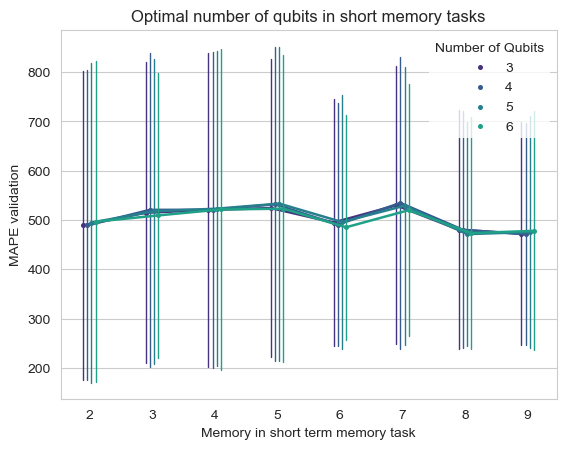

In [6]:
_xaxis_column = 'memory'

hue_columns = ['measaxes']
hue_columns = ['memory']
hue_columns = []
hue_columns = ['nqubits']

df, hue = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column = _xaxis_column,
    _change_moi = {'add_y_to_input': False},
    _hue_columns = hue_columns,
    _keep_columns = ['rseed_data'],
    # _cutoff = 30,
    _select_values_range = {'memory': [2, 9]},
)

ax = better_pointplot(
    x = _xaxis_column, y = ymetric, data = df, 
    hue=hue,
    palette=colors_sequential if hue is not None else None,
    dodge=.2,
    errwidth=1.,
    errorbar = "sd", # ci # 95
    # linestyles='none',
    linestyles='-',
    linewidth=1,
    markers = '.',
    xpos=True,
)

# ax = show_average_lines(ax, df, hue_columns, ymetric)

if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_xticks(df[_xaxis_column].unique(), df[_xaxis_column].unique())
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Memory in short term memory task')
legend = ax.legend(frameon=True, title='Number of Qubits')
legend.get_frame().set_linewidth(0.0)
ax.set_title('Optimal number of qubits in short memory tasks')

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.autoscale()

# plt.savefig(f'{plot_path}/{experiment.model_name}_{fname_data}_{_xaxis_column}.svg')
plt.show()

# Lookback

xoffset 1


/Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate/experiments/plotting/plotting.py:150: UserWarning: You passed a edgecolor/edgecolors ([(0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


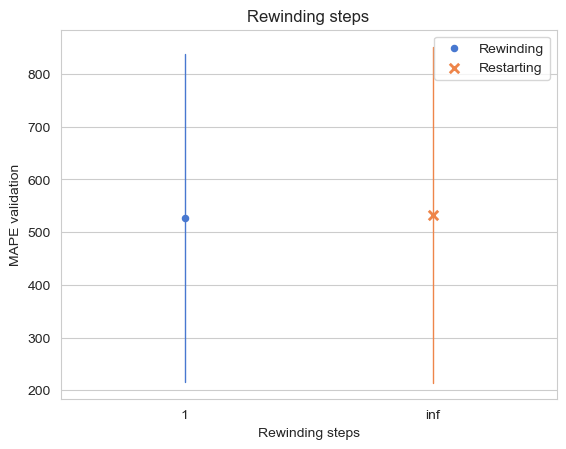

In [7]:
_xaxis_column = 'lookback'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = ['restarting']
hue_columns = ['memory']
hue_columns = []

df, hue = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column = _xaxis_column,
    _change_moi = {'add_y_to_input': False, 'restarting': False, 'lookback_max': False},
    _hue_columns = hue_columns,
    _keep_columns = ['rseed_data'],
    # _cutoff = 30,
)

# sort
df[_xaxis_column] = df[_xaxis_column].astype(int)

# plot primary
ax = better_pointplot(
    x = _xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    dodge=.1,
    errorbar = "sd", # ci # 95
    errwidth=1,
    markers='.',
    hue=hue,
    # palette=colors_sequential,
    label='Rewinding',
)

#####################################################################

xlim = ax.get_xlim()
ylim = ax.get_ylim()

df_secondary, _ = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column = _xaxis_column,
    _change_moi = {'add_y_to_input': False, 'restarting': True},
    _hue_columns = hue_columns,
    _keep_columns = ['rseed_data'],
)

# add fake rows to df_secondary
xoffset = len(df[_xaxis_column].unique())
print('xoffset', xoffset)

# _x_pos_secondary = -1
# df_secondary[_xaxis_column] = _x_pos_secondary
ax = better_pointplot(
    x = _xaxis_column, y = ymetric, data = df_secondary, 
    linestyles='none',
    hue=hue,
    # palette=colors_sequential,
    color=colors[1],
    dodge=.1,
    errorbar = "sd", # ci # 95
    errwidth=1,
    ax=ax,
    markers='x',
    label='Restarting',
    xoffset=xoffset,
)

xlim = [min(xlim[0], ax.get_xlim()[0]), max(xlim[1], ax.get_xlim()[1])+1]
ylim = [min(ylim[0], ax.get_ylim()[0]), max(ylim[1], ax.get_ylim()[1])]

# ax = show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Rewinding steps')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Rewinding steps')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks(
    [*range(len(df[_xaxis_column].unique())+1)],
    [*[str(_c) for _c in df[_xaxis_column].unique()], 'inf'],
)
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{_xaxis_column}.svg')
ax.legend()
plt.show()

# Noise

IndexError: list index out of range

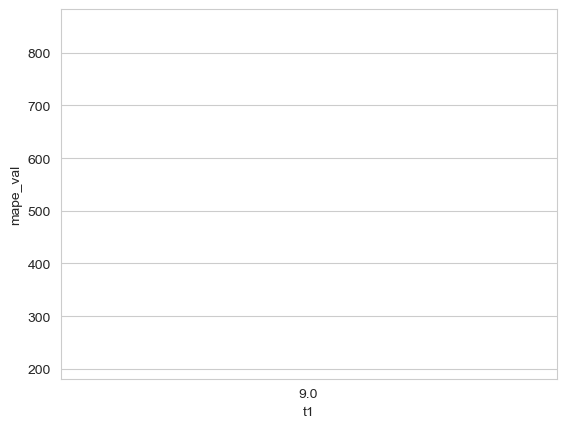

In [8]:
_xaxis_column = 't1'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = ['restarting']
hue_columns = ['memory']
hue_columns = []

df, hue = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column = _xaxis_column,
    _change_moi = {'add_y_to_input': False, 'sim': 'thermal'},
    _hue_columns = hue_columns,
    _keep_columns = ['rseed_data'],
    # _cutoff = 30,
)

# average over different runs where paras are the same, e.g. same rseed_data
# df = average_df(df, passable_model_params + passable_data_params)

# sort
df[_xaxis_column] = df[_xaxis_column].astype(float)
df = df.sort_values(_xaxis_column)

xmin, xmax = 0, 12
xmin, xmax = 8.9, 9.8
df = select_values_range(df, _xaxis_column, xmin, xmax)

# plot primary
ax = better_pointplot(
    x = _xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    dodge=.1,
    errorbar = "sd", # ci # 95
    errwidth=1,
    hue=hue,
    label='T1, T2 Noisemodel',
    xpos=True,
    markers='.',
)

#####################################################################

df_secondary, _ = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column = _xaxis_column,
    _change_moi = {'add_y_to_input': False, 'sim': 'aer_simulator'},
    _hue_columns = hue_columns,
    _keep_columns = ['rseed_data'],
)

df_secondary = average_df(df_secondary, passable_model_params + passable_data_params)

xsort = sorted(df[_xaxis_column].unique())
_x_pos_secondary = xsort[-1] + abs(xsort[-1] - xsort[-2])
df_secondary[_xaxis_column] = _x_pos_secondary
print('_x_pos_secondary', _x_pos_secondary)
ax = better_pointplot(
    x = _xaxis_column, y = ymetric, data = df_secondary, 
    linestyles='none',
    hue=hue,
    dodge=.1,
    errorbar = "sd", # ci # 95
    errwidth=1,
    ax=ax,
    color=colors[1],
    markers='x',
    label='Exact',
    xpos=True,
)


ax.set_title('Noise')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('T1 [microseconds]')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')

# 5.9 = time of circuit for one timestep
ax.set_ylim(ax.get_ylim())
# ax.vlines(x = [5.9], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dotted', colors='gray', label='One timestep')
# ax.vlines(x = [5.9*2], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', colors='gray', label='Two timesteps')
# ax.margins(.1)
ax.autoscale()

# noiseless as horizontal line

# secax = ax.secondary_xaxis('top', functions=(lambda x: x*7/5, lambda x: x*5/7))
secax = ax.secondary_xaxis('top')
secax.tick_params(width=0, length=0)
secax.set_xlabel('T2 [microseconds]')

# secax.invert_xaxis()
ax.invert_xaxis()

# secax.set_xscale('log')
# ax.set_xscale('log')

ticks_all = [_x_pos_secondary, *list(df[_xaxis_column].unique())]
labels_t1 = ['inf', *[f'{_c:.1f}' for _c in df[_xaxis_column].unique()]]
labels_t2 = ['inf', *[f'{_c*7/5:.1f}' for _c in df[_xaxis_column].unique()]]
ticks, labels_t1 = sparse_ticks(ticks_all, labels_t1, 20)
ticks, labels_t2 = sparse_ticks(ticks_all, labels_t2, 20)
ax.set_xticks(ticks, labels_t1, size=8) 
secax.set_xticks(ticks, labels_t2, size=8)

legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{_xaxis_column}_jump_avg.svg')
plt.show()

In [ ]:
_xaxis_column = 't1'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = ['restarting']
hue_columns = []

df, hue = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column = _xaxis_column,
    _change_moi = {'add_y_to_input': False, 'sim': 'thermal'},
    _hue_columns = hue_columns,
    _keep_columns = ['rseed_data'],
    # _cutoff = 30,
)

# average over different runs where paras are the same, e.g. same rseed_data
# df = average_df(df, passable_model_params + passable_data_params)

# sort
df[_xaxis_column] = df[_xaxis_column].astype(float)
df = df.sort_values(_xaxis_column)

# only take values in this list
df = select_values_range(df, _xaxis_column, 0, 12)
# df = select_values(
#     df, _xaxis_column, 
#     [0., 1., 0.1, .5, 2., 3., 4., 5.,  6., 7., 8., 9., 10.]
# )


# plot primary
ax = sns.scatterplot(
    x = _xaxis_column, y = ymetric, data = df, 
    hue=hue,
    label='T1, T2 Noisemodel',
)

################################

df_secondary, _ = get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    _xaxis_column=_xaxis_column,
    _change_moi = {'add_y_to_input': False, 'sim': 'aer_simulator'},
    _keep_columns = ['rseed_data'],
)

# _x_pos_secondary = len(df[_xaxis_column].unique())
_x_pos_secondary = max(df[_xaxis_column].unique()) + abs(df[_xaxis_column].unique()[-1] - df[_xaxis_column].unique()[-2])
df_secondary[_xaxis_column] = _x_pos_secondary
# df_secondary = df_secondary[df_secondary['restarting'] == True]
# df_secondary = df_secondary.groupby('rseed_data').mean().reset_index()
ax = sns.scatterplot(
    x = _xaxis_column, y = ymetric, data = df_secondary, 
    hue=hue,
    label='Exact',
    markers='x',
    ax=ax,
)

# ax = show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Noise')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('T1 [microseconds]')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')

# 5.9 = time of circuit for one timestep
ax.set_ylim(ax.get_ylim())
ax.vlines(x = [5.9], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dotted', colors='gray', label='One timestep')
ax.vlines(x = [5.9*2], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', colors='gray', label='Two timesteps')

# noiseless as horizontal line

# secax = ax.secondary_xaxis('top', functions=(lambda x: x*7/5, lambda x: x*5/7))
secax = ax.secondary_xaxis('top')
secax.tick_params(width=0, length=0)
secax.set_xlabel('T2 [microseconds]')

# secax.invert_xaxis()
ax.invert_xaxis()

# secax.set_xscale('log')
# ax.set_xscale('log')

ticks_all = [_x_pos_secondary] + list(df[_xaxis_column].unique())
labels_t1 = ['inf', *[f'{_c:.1f}' for _c in df[_xaxis_column].unique()]]
labels_t2 = ['inf', *[f'{_c*7/5:.1f}' for _c in df[_xaxis_column].unique()]]
ticks, labels_t1 = sparse_ticks(ticks_all, labels_t1, 20)
ticks, labels_t2 = sparse_ticks(ticks_all, labels_t2, 20)
# ax.set_xticks(ticks, labels_t1, size=8) 
# secax.set_xticks(ticks, labels_t2, size=8)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), size=8)
# secax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), size=8)
secax.set_xticks(ax.get_xticks(), [f'{float(_t.get_text())*7/5:.1f}' for _t in ax.get_xticklabels()], size=8)

ax.autoscale(axis="x", tight=False)

legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{_xaxis_column}_all.svg')
plt.show()

# Time for Ising: 5.85 [microseconds]
# T1 when results detirioate: 9 - 9.5 [microseconds]
# T2 when results detirioate: 13 [microseconds]